[591.8, 607.6, 597.6, 584.6, 582.0, 596.2]
Using 3d array processing as lat, lon, and elevation were provided.
[[ 0.01203378  0.05675638  0.0074537  -0.04265749 -0.03699895  0.00341258]
 [ 0.05757267 -0.00817152 -0.04772992 -0.03157196  0.02748655  0.00241418]
 [-0.0015      0.0143      0.0043     -0.0087     -0.0113      0.0029    ]]


c:\Users\csaunders-shultz\Documents\GitHub\lts_array\lts_array\classes\lts_data_class.py:193: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


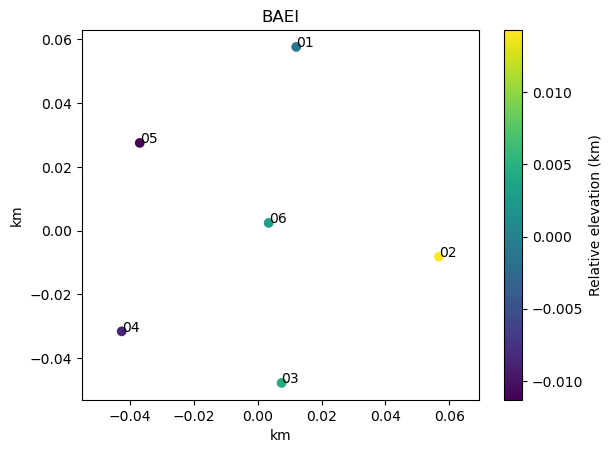

In [1]:
# lts testing
import lts_array
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime


#Tools to test
#from lts_array.classes.lts_data_class import DataBin
#lts_array.classes.lts_classes.OLSEstimator
#lts_array.classes.lts_classes.LTSEstimator

#get stream for testing
NET = "AV"
STA = "BAEI"
LOC = "*"
CHAN = "HDF"
START = UTCDateTime("2023-07-14 01:02:44") - 20
END = START + 60
client = Client("IRIS")
st = client.get_waveforms(NET, STA, LOC, CHAN, START, END, attach_response=True)
st.merge(fill_value="latest")
st.trim(START, END, pad="true", fill_value=0)
st.sort()
st.remove_sensitivity()
# Filter the data
st.filter("bandpass", freqmin=1, freqmax=20, corners=2, zerophase=True)
st.taper(max_percentage=0.05)
inv = client.get_stations(
    network=NET,
    station=STA,
    channel=CHAN,
    location=LOC,
    starttime=START,
    endtime=END,
    level="channel",
)
lat_list = []
lon_list = []
elevation_list = []  # meters
staname = []
for network in inv:
    for station in network:
        for channel in station:
            lat_list.append(channel.latitude)
            lon_list.append(channel.longitude)
            elevation_list.append(channel.elevation)
            staname.append(channel.code)

print(elevation_list)

data = lts_array.classes.lts_data_class.DataBin(window_length=10, window_overlap=0.8, alpha=0.7)
data.build_data_arrays(st, lat_list, lon_list, elevation_list, remove_elements=None)# rij)

data.plot_array_coordinates()
print(data.rij)

Using 2D array processing as only lat and lon were provided.
ALPHA is 1.00. Performing an ordinary least squares fit, NOT least trimmed squares.
Using 3d array processing as lat, lon, and elevation were provided.
ALPHA is 1.00. Performing an ordinary least squares fit, NOT least trimmed squares.
[[-4.03011204]
 [-4.99675763]
 [24.22780859]]
[[-0.59709314]
 [-2.9628738 ]
 [-1.56155967]]
[[-4.47381809]
 [-4.85736924]
 [25.71712976]]
[[-0.66249187]
 [-2.97507139]
 [-1.20554277]]
[[-0.52408621]
 [-3.01055594]
 [-1.7617123 ]]
[[-0.60598887]
 [-2.98281564]
 [-1.28835072]]
[[-2.50834489]
 [-1.83307751]
 [ 2.38728758]]
[[-1.90546155]
 [ 2.26074451]
 [ 0.85418386]]
[[-2.13971248]
 [ 2.28572294]
 [ 1.68904417]]
[[-2.13971248]
 [ 2.28572294]
 [ 1.68904417]]
[[-2.13971248]
 [ 2.28572294]
 [ 1.68904417]]
[[-2.13971248]
 [ 2.28572294]
 [ 1.68904417]]
[[-2.13971248]
 [ 2.28572294]
 [ 1.68904417]]
[[-2.13971248]
 [ 2.28572294]
 [ 1.68904417]]
[[-1.99773506]
 [ 2.22958206]
 [ 0.97535871]]
[[-2.1179662 

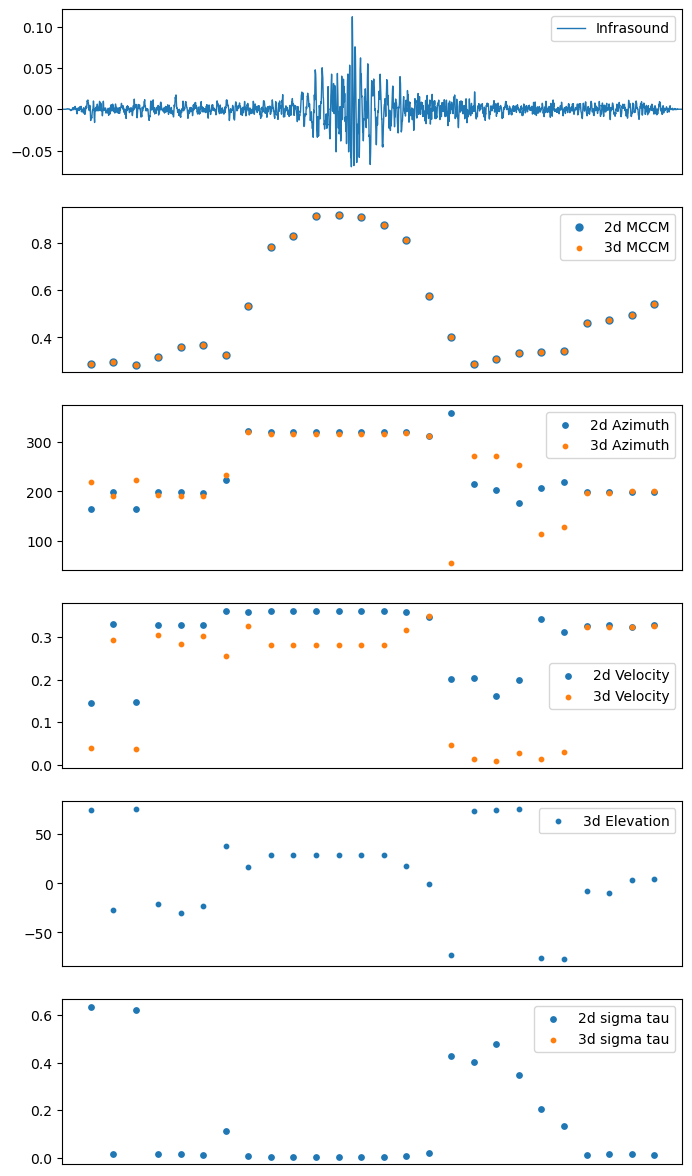

In [5]:
import numpy as np
import matplotlib.pyplot as plt
#First, make sure that the 2d and 3d models return the same results
#They return different results so something is happening even before we get to solve
#Testing reveals tau are equal, so correlate produces the same result

#Check 2d
data2 = lts_array.classes.lts_data_class.DataBin(window_length=10, window_overlap=0.8, alpha=1.0)
data2.build_data_arrays(st, lat_list, lon_list, remove_elements=None)# rij)
ltsva2 = lts_array.classes.OLSEstimator(data2)
ltsva2.correlate(data2)
ltsva2.solve(data2)
#fig, axs = lts_array.tools.lts_array_plot(st, ltsva2.lts_vel, ltsva2.lts_baz, ltsva2.t, ltsva2.mdccm, ltsva2.stdict)
#print(ltsva.lts_vel)

#Check 3d
data3 = lts_array.classes.lts_data_class.DataBin(window_length=10, window_overlap=0.8, alpha=1.0)
data3.build_data_arrays(st, lat_list, lon_list, elevation_list, remove_elements=None)# rij)
ltsva3 = lts_array.classes.OLSEstimator(data3)
ltsva3.correlate(data3)
ltsva3.solve_3d(data3)
#fig, axs = lts_array.tools.lts_array_plot(st, ltsva3.lts_vel, ltsva3.lts_baz, ltsva3.t, ltsva3.mdccm, ltsva3.stdict)
#print(ltsva.lts_vel)

#testing
print(f"Timesteps are equal --> {np.array_equal(ltsva2.t, ltsva3.t)}")
print(f"Lts_vel are equal --> {np.array_equal(ltsva2.lts_vel, ltsva3.lts_vel)}")
print(f"tau are equal --> {np.array_equal(ltsva2.tau, ltsva3.tau)}")

print(f"data.rij are equal --> {np.array_equal(data2.rij, data3.rij)}") # distance from mean point in km
print(f"xij are equal --> {np.array_equal(ltsva2.xij, ltsva3.xij)}") # relative sensor locations for all pairs
print(f"xij_mad are equal --> {np.array_equal(ltsva2.xij_mad, ltsva3.xij_mad)}") #relative sensor locations, 

#Plot actual results
fig, axs = plt.subplots(nrows=6, figsize=(8,15))
t = ltsva2.t

#data
axs[0].plot(st[0], lw=1, label='Infrasound')
axs[0].set_xlim((0,len(st[0])))

#mccm
axs[1].scatter(t, ltsva2.mdccm, s=25, label='2d MCCM')
axs[1].scatter(t, ltsva3.mdccm, s=10, label='3d MCCM')

#azimuth
axs[2].scatter(t, ltsva2.lts_baz, s=15, label='2d Azimuth')
axs[2].scatter(t, ltsva3.lts_baz, s=10, label='3d Azimuth')

#Velocity
axs[3].scatter(t, ltsva2.lts_vel, s=15, label='2d Velocity')
axs[3].scatter(t, ltsva3.lts_vel, s=10, label='3d Velocity') #should be... lower? than 2d

#Elevation
axs[4].scatter(t, ltsva3.lts_elev, s=10, label='3d Elevation')

#sigma tau
axs[5].scatter(t, ltsva2.sigma_tau, s=15, label='2d sigma tau')
axs[5].scatter(t, ltsva3.sigma_tau, s=10, label='3d sigma tau')


for ax in axs:
    ax.legend()
    ax.set_xticks(())
